In [1]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Ticketmaster Data

In [2]:
df = pd.read_csv("ticket_df.csv")

#Eliminating rows that don't have prices
df = df[df['min_price'].notna()]

#Adding new column which is the average of price (min and max)
df["average_price_eur"] = df[["min_price_eur","max_price_eur"]].mean(axis=1)

df.head()

,name,type,id,url,locale,date,date_status,segment,genre,subgenre,...,max_price,venue_name,venue_type,venue_timezone,city,country,country_code,min_price_eur,max_price_eur,average_price_eur
0,Lady Antebellum: Ocean Tour 2020,event,vv1A8vbu9GA1wxeC,https://concerts.livenation.com/lady-antebellu...,en-us,2020-09-20,rescheduled,Music,Country,Country,...,200.00,Bank of New Hampshire Pavilion,venue,America/New_York,Gilford,United States Of America,US,35.234121,185.442745,110.338433
1,Eagles,event,vv1AkZAq8GkezVfHD,https://www.ticketmaster.com/eagles-saint-paul...,en-us,2020-10-16,rescheduled,Music,Rock,Pop,...,767.00,Xcel Energy Center,venue,America/Chicago,Saint Paul,United States Of America,US,116.828929,711.172925,414.000927
2,Eagles,event,vv1AkZAq8GkezgfTh,https://www.ticketmaster.com/eagles-saint-paul...,en-us,2020-10-17,rescheduled,Music,Rock,Pop,...,767.00,Xcel Energy Center,venue,America/Chicago,Saint Paul,United States Of America,US,116.828929,711.172925,414.000927
3,Eagles,event,G5vYZ4VqSWoX_,https://www.ticketmaster.com/eagles-san-franci...,en-us,2020-10-02,rescheduled,Music,Rock,Pop,...,750.00,Chase Center,venue,America/Los_Angeles,San Francisco,United States Of America,US,119.610570,695.410292,407.510431
4,Eagles,event,1kk8v94-GA5YE-w,https://www.ticketmaster.com/eagles-phoenix-ar...,en-us,2020-10-24,rescheduled,Music,Rock,Pop,...,745.25,Talking Stick Resort Arena,venue,America/Phoenix,Phoenix,United States Of America,US,87.389893,691.006027,389.197960


## Country Indicators

In [3]:
stat = pd.read_excel("country_data.xls")

"""stat.head().columns
'Unnamed: 0',
       'Audio-visual, photographic and information processing equipment',
       'Other major durables for recreation and culture',
       'Other recreational items and equipment, gardens and pets',
       'Recreational and cultural services',
       'Newspapers, books and stationary', 'Population', 'Tourism Arrivals',
       'GPD pp'],"""

column_names = ["country_code","Equipment","Durables","Other items","Services","Newspapers and books",
                "Population","Tourism Arrivals","GDP_pp"]

stat.columns = column_names

#The expenditure in recreation was by total population, so we divide it by the population to get the value per capita
stat[["Equipment","Durables","Other items","Services","Newspapers and books"]] = stat[["Equipment","Durables","Other items","Services","Newspapers and books"]].div(stat.Population, axis=0)
stat.head()

#Since the dataframe is in usd, we need to transform it into eur
exchange = requests.get("https://api.exchangeratesapi.io/latest")
exchange = exchange.json()
exchange = pd.DataFrame(json_normalize(exchange).T)

stat[["Equipment","Durables","Other items","Services","Newspapers and books","GDP_pp"]] = stat[["Equipment","Durables","Other items","Services","Newspapers and books","GDP_pp"]].div(exchange.loc["rates.USD"][0], axis=0)

#The Total column is the column that agregates all types of expenditure with recreation and culture
stat["Culture Expenditure"] = stat["Equipment"] + stat["Durables"] + stat["Other items"] + stat["Services"] + stat["Newspapers and books"]

#Changing to the same country codes 
stat["country_code"] = ["US","CA","GB","IE","MX","NZ"]
stat.head(7)

/Users/telmabatista/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,country_code,Equipment,Durables,Other items,Services,Newspapers and books,Population,Tourism Arrivals,GDP_pp,Culture Expenditure
0,US,997.451863,187.834457,829.255520,976.532878,282.275936,327200000.0,79745920,58224.014835,3273.350653
1,CA,241.437179,159.422794,443.066820,810.634172,123.345572,37590000.0,21134000,42867.872045,1777.906537
2,GB,464.155040,272.692384,781.892370,951.273830,204.406805,66440000.0,36316000,39818.173389,2674.420429
3,IE,38.994251,1.657342,242.417667,753.518757,145.538762,4830000.0,10926000,73070.375522,1182.126779
4,MX,99.821023,4.329802,37.947761,72.951940,26.307494,129200000.0,41313000,8969.309226,241.358020
5,NZ,212.706225,97.476474,270.348652,712.277806,230.790532,4794000.0,3709967,38892.257765,1523.599689


## Merged Dataframe

In [4]:
df.groupby(["country_code"]).count()

merged = pd.merge(df,stat, on="country_code")

merged.head()

print(list(merged.columns))

['name', 'type', 'id', 'url', 'locale', 'date', 'date_status', 'segment', 'genre', 'subgenre', 'class_type', 'subtype', 'price_type', 'currency', 'min_price', 'max_price', 'venue_name', 'venue_type', 'venue_timezone', 'city', 'country', 'country_code', 'min_price_eur', 'max_price_eur', 'average_price_eur', 'Equipment', 'Durables', 'Other items', 'Services', 'Newspapers and books', 'Population', 'Tourism Arrivals', 'GDP_pp', 'Culture Expenditure']


In [5]:
#Choosing price variable for correlation

price = input("Choose between 'min_price_eur','max_price_eur','average_price_eur': ")

Choose between 'min_price_eur','max_price_eur','average_price_eur': min_price_eur


In [6]:
merged = merged.groupby(["Tourism Arrivals","Culture Expenditure","Population","GDP_pp"])[price].mean()
merged = merged.to_frame()
merged = merged.reset_index()

In [7]:
merged.head()

,Tourism Arrivals,Culture Expenditure,Population,GDP_pp,min_price_eur
0,3709967,1523.599689,4794000.0,38892.257765,31.348153
1,10926000,1182.126779,4830000.0,73070.375522,50.081813
2,21134000,1777.906537,37590000.0,42867.872045,37.255910
3,36316000,2674.420429,66440000.0,39818.173389,89.584519
4,41313000,241.358020,129200000.0,8969.309226,78.137643


In [8]:
series = merged[merged.columns[0:4]].apply(lambda x: x.corr(merged[price]))

print(series)

Tourism Arrivals       0.524742
Culture Expenditure    0.115958
Population             0.351480
GDP_pp                -0.347411
dtype: float64


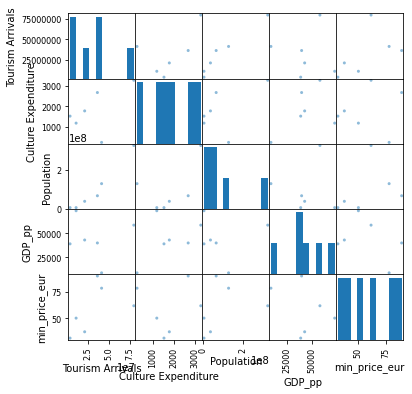

In [9]:
scatter_matrix(merged, figsize=(6,6))
plt.show()